## Background

House price has always been an serious social issue in Taiwan, especially in Taipei city. The nation-wide house price to income ratio revealed by Taiwanese government is around 8.62 in 2020(**[1]**). For Taipei city is around 14.39. If we compare these values with Demographia International Housing Affordability Survey 2019(**[2]**), it's not hard to realize that this such a high number. 

Therefore, I would like to build a regression model trying to predict the housing price in Taipei city, the capital city of Taiwan. In this project, we want to firstly figure out some trend of housing transaction from exploratory analysis. Then we want to build a linear regression model to predict housing price using features we have. Finally, we wish to find out the most positively influential and negatively influential feature that affects housing price. In addition, we can examine the results with our exploratory observation

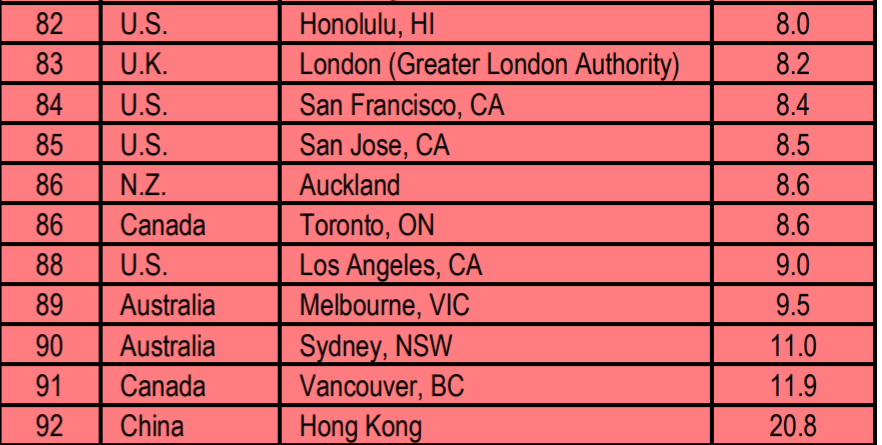

## About Dataset

 This dataset is downloaded from Kaggle(**[3]**). This dataset contains some useful information about recent real estate transaction in Taipei city, the original data mainly comes from open data of Ministry of the Interior of Taiwan(**[4]**).

### Import Libraries
Before importing our dataset of desired, we have to import necessary Python modules

In [ ]:
#Import necessary libraries
import pandas as pd
import numpy as np
import csv 
import math
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
pd.options.display.max_columns = 50
%matplotlib inline

### Import Dataset
Now let's import our dataset and check the first few rows with head method.

In [ ]:
#We import dataset as "Resident_Dataset" which we already filtered out other data not for resident use.
Resident_Dataset = pd.read_csv('2020_H2_Resident_ENG.csv')
Shape = Resident_Dataset.shape

#Let's see how the dataset looks like
Resident_Dataset.head()

## Data Cleaning and Feature Engineering

### Data Transformation
In this cell, we transform some of the column into quantity per unit land or building.

Also, we do some feature engineering to create some new features for later analysis.

In [ ]:
#We do not take transaction data with 0 room into consideration
Resident_Dataset = Resident_Dataset[Resident_Dataset["num_room"]!=0]

# This part average land shifting total area with number of land transaction.
Resident_Dataset["land shifting total area per unit transaction"] = Resident_Dataset["land shifting total area"]/Resident_Dataset["num_land"]
Resident_Dataset["land shifting total area per unit transaction"].replace(np.inf, np.nan, inplace = True)
Resident_Dataset["land shifting total area per unit transaction"].fillna(0,inplace = True)

# This part average building shifting total area with number of building transaction.
Resident_Dataset["building shifting total area per unit transaction"] = Resident_Dataset["building shifting total area"]/Resident_Dataset["num_building"]

#This part average some other columns with number of building
Resident_Dataset["num_room"] = Resident_Dataset["num_room"]/Resident_Dataset["num_building"]
Resident_Dataset["num_bathroom"] = Resident_Dataset["num_bathroom"]/Resident_Dataset["num_building"]
Resident_Dataset["main building area"] = Resident_Dataset["main building area"]/Resident_Dataset["num_building"]
Resident_Dataset["balcony area"] = Resident_Dataset["balcony area"]/Resident_Dataset["num_building"]
Resident_Dataset["subsidiary building area"] = Resident_Dataset["subsidiary building area"]/Resident_Dataset["num_building"]

#This part adds some derived feature to the dataset
#This line create total shifting area per unit transaction
Resident_Dataset["total shifting area per unit transaction"] = Resident_Dataset["land shifting total area per unit transaction"] + Resident_Dataset["building shifting total area per unit transaction"]

#This line create building age at transaction
Resident_Dataset["building age at transaction"] = Resident_Dataset['transaction year'] - Resident_Dataset['complete year']

#This line create main building ratio by taking main building area over building shifting total area
Resident_Dataset["main building ratio"] = Resident_Dataset["main building area"]/Resident_Dataset["building shifting total area"]

#This line create unit price without carpark price included
Resident_Dataset["unit ntd nocarpark"] = (Resident_Dataset["total ntd"] - Resident_Dataset["carpark total price"])/Resident_Dataset["building shifting total area"]

#Resident_Dataset[Resident_Dataset["building age at transaction"] < 0 ] = 0

#Finally, we check first few rows of our dataset
#Raw_Resident_Dataset = Resident_Dataset.copy()
#Resident_Dataset.drop(columns=["carpark total price","num_garage","carpark shifting area","carpark type","land shifting total area","building shifting total area","num_land","num_building","transaction year","complete year","total ntd","unit ntd"], inplace = True)
Resident_Dataset.head()

This cell filters our features with abnormally high quantity of rooms and bathrooms. (7 per unit building transaction in our case)

In [ ]:
#According to common sense, it is abnormal for a single building to have more than 6 rooms and bathrooms
#Thus we filter out data not within this range.
Resident_Dataset = Resident_Dataset[Resident_Dataset["num_room"] <= 7]
Resident_Dataset = Resident_Dataset[Resident_Dataset["num_bathroom"] <= 7]

### Checking Duplicates
In this cell, we check if there are duplicated rows and found that there are 44 duplicated rows

In [ ]:
#We use duplicated method to find out duplicated rows and print our results
num_duplicated = sum(Resident_Dataset.duplicated(keep = "first"))
print("There are " + str(num_duplicated) + " duplicated rows in this dataset")

#Then, we update our dataset to no duplicate one
Resident_Dataset = Resident_Dataset[~Resident_Dataset.duplicated(keep = "first")]
display(Resident_Dataset.head())

#Check again to see if there are duplicates
num_duplicated = sum(Resident_Dataset.duplicated(keep = "first"))
print("There are " + str(num_duplicated) + " duplicated rows in this dataset after cleaning")

### Checking and Removing NAN
Result shows there are only 4 columns are with NaN or Null value, and proportion of it are all less than 1%

In [ ]:
#We build a dataframe to exhibit the percentage of NaN or Null value 
NAN_Rate = pd.DataFrame(data={"% of NAN":Resident_Dataset.isna().sum()/Shape[0]})
NAN_Rate[NAN_Rate["% of NAN"]!=0]

Subsequently, we remove those rows with NaN or Null since it only occupies less than 1 % of the dataset

In [ ]:
#Check NAN rows
for cols in list(Resident_Dataset.columns):
    Resident_Dataset = Resident_Dataset[~Resident_Dataset[cols].isna()]

#Print out current shape of Resident Dataset
print("Shape of Resident_Dataset is now " + str(Resident_Dataset.shape))

#Clone resident dataset for exploratory data analysis
Raw_Resident_Dataset = Resident_Dataset.copy()

#Drop columns that we will not use in modeling process
Resident_Dataset.drop(columns=["carpark total price","num_garage","carpark shifting area","carpark type","land shifting total area","building shifting total area","num_land","num_building","transaction year","complete year","total ntd","unit ntd"], inplace = True)
Resident_Dataset.head()

### Distribution of Numerical Variables

First extract numerical columns from original dataset based on column data type. In this step, we also abandoned some numerical columns that is considered discrete and non-quatitative variable. There are 12 different numerical features in our dataset. 

In [ ]:
#We create a table listing data types of all columns 
#and pick up numerical ones based on their data type
Type_Table = pd.DataFrame(data={"dtype":Resident_Dataset.dtypes})
Numerical_Columns = list(Type_Table[Type_Table["dtype"] != "object"].index)
"num_land","num_building"
#Remove column management_org in numerical cloumns because it's dummy variable type numerical
#Remove transaction year,month and complete year because they are discrete and non-quatitative variables
try:
    Numerical_Columns.remove("management org")
    Numerical_Columns.remove("elevator")
    Numerical_Columns.remove("unit ntd nocarpark")
    Numerical_Columns.remove("compartment")
except:
    pass

#Report results of numerical columns
print("We have " + str(len(Numerical_Columns))+" numerical features.")
print("Numerical Columns are :\n" + str(Numerical_Columns))

Second, we visualize the distribution of numerical variables using histogram. You can see there are a lot of right skewed distribution.

In [ ]:
fig = plt.figure(figsize = [30,30])
sub_ind = 1
for cols in Numerical_Columns:
    Resident_Dataset[cols].plot.hist(ax = plt.subplot(6,2,sub_ind), bins =25, title = cols)
    sub_ind += 1

### Statistics of Numerical Variable and Outlier (More like extreme values) Rejection
This cell creates a  statistical table listing 1.5IQR information. We will reference the table to eliminate data points that is not considered normal condition at all.

In [ ]:
#Create list for storing statistical value
Num_Max = []
Num_min = []
mean_lst = []
stdlist = []
stdup = []
stdlow = []
IQRup = []
IQRlow = []

#Iterate through numerical columns
for cols in Numerical_Columns:
    #Acquire basic statistical values
    mean = Resident_Dataset[cols].mean()
    std = Resident_Dataset[cols].std()
    Q1 = Resident_Dataset[cols].quantile(0.25)
    Q3 = Resident_Dataset[cols].quantile(0.75)
    mean_lst.append(mean)
    stdlist.append(std)
    #Calculate IQR limits
    IQR = Q3 - Q1
    Num_Max.append(Resident_Dataset[cols].max())
    Num_min.append(Resident_Dataset[cols].min())
    IQRup.append(Q3 + 1.5*IQR)
    IQRlow.append(Q1 - 1.5*IQR)

#Cast lists to the dataframe
Numerical_Columns_Stats = pd.DataFrame({"Feature":Numerical_Columns,"Max":Num_Max,"min":Num_min,"Mean":mean_lst,"std":stdlist ,"IQRup":IQRup,"IQRlow":IQRlow})
Numerical_Columns_Stats.index = Numerical_Columns_Stats["Feature"]
Numerical_Columns_Stats.drop(columns = ["Feature"], inplace = True)
Numerical_Columns_Stats

We scan through numerical rows and cut off data point with value greater than limitation defined by 1.5IQR method.

In [ ]:
#Define feature requiring cleaning
clean_columns = ["main building area", "subsidiary building area", "balcony area",\
                "land shifting total area per unit transaction", "building shifting total area per unit transaction",\
                 "total shifting area per unit transaction"]

#Iteratively clean the features
for cols in clean_columns:
    threshold = Numerical_Columns_Stats.loc[cols,"IQRup"]
    Resident_Dataset = Resident_Dataset[Resident_Dataset[cols] < threshold]

#Show the present shape of dataset 
Resident_Dataset.shape

In this cell, we further clean the dataset according to our prediction goal (unit ntd nocarpark). We would like to remove some extreme data of unit_ntd column because these values may not reflect normal housing transaction behavior compared to those inside our range of interest.

We will apply 1.5\*IQR method filter our data. After filtration, you can see the close to symmetry distribution of unit ntd nocarpark

In [ ]:
#In order to get a more general model that can fit non-extreme cases,
#We will abandon first and last 1% of data after sorting with unit ntd.
old_unit_ntd = Resident_Dataset["unit ntd nocarpark"]
percent_1 = Resident_Dataset.shape[0]*0.01
Resident_Dataset = Resident_Dataset.sort_values(by=['unit ntd nocarpark']).iloc[int(percent_1):-int(percent_1),:]

#Plot to show distribution before and after cleaning dependent variable
plt.figure(figsize = [15,8])
plt.hist(old_unit_ntd, bins = 100,alpha=0.5)
plt.hist(Resident_Dataset["unit ntd nocarpark"], bins = 100, alpha = 0.8)
plt.xlabel("Unit ntd nocarpark")
plt.ylabel("Frequency")
plt.legend(["Original Data","Cleaned Data 2%"])
plt.title("Distribution of Unit ntd after cutting 2% data")


## Exploratory Data Analysis

### Analysis Based on District
In this part, we will analyze raw data of each district and try to observe trending of housing transaction
in second half of 2020. To start we create a new dataframe to store some aggregated or average value of our 
variables.

In [ ]:
#Create dataframe for district analysis
District_Analysis = pd.DataFrame(columns = ["district","num_building", "num_land", "land shifting total area per unit transaction", "building shifting total area per unit transaction", "main building ratio", "building age at transaction", "unit ntd nocarpark"])

#Iterate through district to get average or summation value of features
for dist in list(Raw_Resident_Dataset['district'].unique()):
    Temp_Series_Mean = Raw_Resident_Dataset[Raw_Resident_Dataset['district'] == dist].mean()
    Temp_Series_Sum = Raw_Resident_Dataset[Raw_Resident_Dataset['district'] == dist].sum()
    Temp_Row = {'district':dist}
    for feat in list(District_Analysis.columns):
        #We want summation value of num_building and num_land
        if feat in ["num_building","num_land"]:
            Temp_Row[feat] = Temp_Series_Sum[feat]
        #We want mean value of other features
        elif feat != 'district':
            Temp_Row[feat] = Temp_Series_Mean[feat]   
    #Append the row onto dataframe
    District_Analysis = District_Analysis.append(Temp_Row, ignore_index = True)
#Reset the index with district name
District_Analysis.index = Raw_Resident_Dataset['district'].unique()
District_Analysis

This cell imports geojson file and folium libraries we need to make the choropleth map. Also, we translate Chinese TOWNNAME into English one.

In [ ]:
#Import modules for acquiring geojson
from urllib.request import urlopen
import json
#Import geojson from Github
with urlopen('https://raw.githubusercontent.com/g0v/twgeojson/master/json/twTown1982.geo.json') as response:
    geo_taipei = json.load(response)  #Collect geojson data from Github

#Dictionary used for translation of district name
district_dict = {"文山區":"Wenshan District",\
                                  "中正區":"ZhongZheng District",\
                                  "內湖區":"Neihu District",\
                                  "萬華區":"Wanhua District",\
                                  "中山區":"Zhongshan District",\
                                  "南港區":"Nangang District",\
                                  "大同區":"Datong District",\
                                  "松山區":"Songshan District",\
                                  "大安區":"Daan District",\
                                  "信義區":"Xinyi District",\
                                  "北投區":"Beitou District",\
                                  "士林區":"Shilin District"}

#Replace Chinese TOWNNAME to English one
for i in range(len(geo_taipei['features'])):
    if geo_taipei['features'][i]['properties']['COUNTYNAME'] == "台北市":     
        geo_taipei['features'][i]['properties']['TOWNNAME'] = district_dict[geo_taipei['features'][i]['properties']['TOWNNAME']]


In this cell, we plot the number of building transaction in each district using a choropleth map. From the map, you can see that some districts that are not in the center of Taipei(ex: Neihu, Beitou) have relatively higher amount of transaction than those lying in the center Taipei. This phenomena more or less illustrates that the housing market may be close to saturation in downtown, more and more people are seeking houses in the suburban area.

In [ ]:
#import folium
import folium

#Creaate a map for choropleth map
map0 = folium.Map(location=[25.06,121.52], zoom_start=11)

#Create choropleth map object with key on TOWNNAME
folium.Choropleth(geo_data = geo_taipei,\
    name="choropleth",\
    data = District_Analysis,\
    columns = ["district","num_building"],\
    key_on='feature.properties.TOWNNAME',\
    fill_color='YlOrRd',\
    fill_opacity=0.7,\
    line_opacity=0.5,\
    legend_name='Taipei',).add_to(map0)

#Create style_function
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

#Create highlight_function
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

#Create popup tooltip object
NIL = folium.features.GeoJson(
    geo_taipei,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['TOWNNAME'],
        aliases=['District'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")))

map0.add_child(NIL)
map0.keep_in_front(NIL)
folium.LayerControl().add_to(map0)

map0

In this cell, we plot the mean housing price per square meter of each district. We found that even though the number of transaction of downtown Taipei may not grow as fast as suburban area, the average housing price is still much higher than suburban area. This may as well be another cause of why nowadays people favor suburban area than downtown.

In [ ]:
#Creaate a map for choropleth map
map1 = folium.Map(location=[25.06,121.52], zoom_start=11)

#Create choropleth map object with key on TOWNNAME
folium.Choropleth(geo_data = geo_taipei,\
    name="choropleth",\
    data = District_Analysis,\
    columns = ["district","unit ntd nocarpark"],\
    key_on='feature.properties.TOWNNAME',\
    fill_color='YlOrRd',\
    fill_opacity=0.7,\
    line_opacity=0.5,\
    legend_name='Taipei',).add_to(map1)

#Create style_function
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
#Create highlight_function
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
#Create popup tooltip object
NIL = folium.features.GeoJson(
    geo_taipei,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['TOWNNAME'],
        aliases=['District'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")))

map1.add_child(NIL)
map1.keep_in_front(NIL)
folium.LayerControl().add_to(map1)

map1

This part exhibits amount of different building state of each district. 

First thing to be noticed is that 
very high proportion of transaction belongs to apartment type, but not houses. This is normal since the 
population density in Taiwan, especially Taipei, is so high that construction companies tend to make most 
use of land.


Secondly, the proportion of high storey building transaction is lower for suburban district ex(Beitou, Shilin, Neihu, Wenshan) Perhaps this is related to the lower average housing price. We should check if this holds after establishing
our predictive model.

In [ ]:
#Create building type table to store building type stats for each district
Building_Type_Table = Raw_Resident_Dataset.groupby(by=["district","building state"], as_index=False).count()

#Create table listing ratio of high storey building
age_buildingstate_table = District_Analysis[['district','building age at transaction']]
high_storey_ratio = []
for dist in list(age_buildingstate_table.index):
    Temp_Table = Building_Type_Table[Building_Type_Table["district"] == dist]
    mean = Temp_Table[Temp_Table['building state'] == 'Apartment_11storeyorgreater'].mean(axis=1)
    sums = Temp_Table["transaction type"].sum()
    ratio = mean/sums
    high_storey_ratio.append(float(ratio))
    
age_buildingstate_table.insert(2,"high storey building ratio",high_storey_ratio)    

#Import seaborn library
import seaborn as sbn

#Plot the result using barplot
plt.figure(figsize = [20,10])
plt.xticks(rotation=45)

Building_State_Plot = sbn.barplot(data=Building_Type_Table,x="district",y='transaction type',hue='building state')
age_buildingstate_table['high storey building ratio'].plot(secondary_y=True,marker='o',style='--',color='red')
Building_State_Plot.set(ylim=(0,700))
Building_State_Plot.legend(loc='upper center')
plt.ylim([-0.35,0.75])
plt.ylabel("high storey building ratio")
plt.legend()

## Feature Selection
### Correlation Analysis
Starting here, we will start our modeling process.\
We first select features for our numerical dataset. Firstly, we import necessary libraries for later regression

In [ ]:
#Import regression modules
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

This cell creates table for numerical variables

In [ ]:
#Create numerical table
Numerical_Table = Resident_Dataset[Numerical_Columns]
Numerical_Table.head()

This cell shows the correlation results of numerical features

In [ ]:
#Add unit ntd nocarpark into dataset for correlation analysis
Numerical_Table2 = pd.concat([Numerical_Table,Resident_Dataset["unit ntd nocarpark"]], axis=1)
Numerical_Corr = pd.DataFrame(abs(Numerical_Table2.corr()["unit ntd nocarpark"]))
Numerical_Corr.columns = ["Correlation Coefficient"]
Numerical_Corr.sort_values(by = "Correlation Coefficient", ascending = False, inplace = True)

#Display correlation results of unit ntd nocarpark
display(Numerical_Corr)

#Plot the correlation results of unit ntd nocarpark
plt.figure(figsize = [20,8])
plt.xticks(rotation = 30)
plt.xlabel("Numerical Feature")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Coefficient of Features to Unit NTD")
plt.plot(Numerical_Corr, marker = 'o') 

Numerical_Columns2 = list(Numerical_Corr[Numerical_Corr["Correlation Coefficient"]>0.15].index)
Numerical_Columns2.remove("unit ntd nocarpark")

del Numerical_Table2

### Unique Categories within Categorical Features
Before converting categorical features, we first briefly inspect the number of different categories in each categorical variable.

In [ ]:
#Check number of unique values (categories) in each feature
Categorical_Unique = {"Categorical_Variable":[],"Unique_Values":[]}
Categorical_Columns = []
for cols in list(Resident_Dataset.columns):
    if cols not in Numerical_Columns and cols != "unit ntd nocarpark":
        Categorical_Columns.append(cols)
        Categorical_Unique["Categorical_Variable"].append(cols)
        Categorical_Unique["Unique_Values"].append(len(Resident_Dataset[cols].unique()))
Categorical_Unique_Table = pd.DataFrame(Categorical_Unique)
Categorical_Unique_Table

### Creating Dummy Variables for Categorical Features
Before turning these variables into dummy variable, we look briefly at the number of unique labels within  the variable

In [ ]:
data_num = Resident_Dataset.shape[0]
fig2,ax2 = plt.subplots(figsize = [30,60])   
ind = 1
#Create proportion dict for storing category percentage content
Proportion_Dict = {}

#Iterate through categorical columns
for var in Categorical_Columns:
    #Create temporary dataframe and do calculations
    Temp_DF = pd.DataFrame(Resident_Dataset[var].value_counts()).reset_index()
    Temp_DF.insert(0,"variable",[var]*Temp_DF.shape[0])
    Temp_DF.columns = ["variable","category","percentage"]
    Temp_DF["percentage"] = Temp_DF["percentage"]/data_num*100
    Temp_DF.set_index(["variable","category"],inplace=True)
    for cats in list(Resident_Dataset[var].unique()):
        if var not in Proportion_Dict.keys():
            Proportion_Dict[var] = {}
        Proportion_Dict[var][cats] = Temp_DF.loc[var,cats]
        
    #Plot the results also iteratively    
    Temp_DF.loc[var].plot(kind="bar", ax = plt.subplot(15,1,ind),title=var,fontsize=15)
    plt.xticks(rotation=15)
    plt.xlabel("Category",fontsize = 18)
    plt.ylabel("Percentage",fontsize = 18)
    plt.title(var,fontsize=22)
    ind+=2


### Meaningless Feature Rejection
In this cell, we will do some feature engineering on categories in features having too few samples. Because this kind of transformation cannot provide effective behavior and may harm the regression algorithm  

In [ ]:
#In this cell, we will do some feature engineering on categories in features having too few samples. 
#Because this kind of transformation cannot provide effective behavior and may harm the regression 
#algorithm  

#Create a new dataset to store data for later regression
Categorical_Dataset = pd.DataFrame()

#For feature transaction_type, we will omit the category "building" and "garage" because they 
#occupied only a very minor part. Also, the concept of these two types are as well exhibited by 
#categories.
exclusion = ["management org","elevator","compartment"]
for var in Categorical_Columns:
    if var not in exclusion:
        Categorical_Dataset = pd.concat([Categorical_Dataset,pd.get_dummies(Resident_Dataset[var],prefix = var)], axis = 1, sort = False)
        for cats in Proportion_Dict[var].keys():
            value = float(Proportion_Dict[var][cats])
            if value < 1:
                Categorical_Dataset.drop(columns = [str(var) + "_" + str(cats)], inplace = True)
    else:
        Categorical_Dataset[var] = Resident_Dataset[var]
        
#Drop some other columns
Categorical_Dataset.drop(columns=["compartment","main building materials_Other"],inplace=True)   
Categorical_Dataset

### Create Final Dataset
Finally, we concatenate categorical and numerical dataset as our final dataset for regression

In [ ]:
Dataset = pd.concat([Categorical_Dataset,Resident_Dataset[Numerical_Columns2]], axis = 1)
Dataset.head(5)

## Regression
### OLS Fitting
We first divide our dataset into training and test set using train_test_split method in Scikit-Learn. Then, we apply Ordinary Least Square (OLS) method in statsmodel.api module to build the model

In [ ]:
#import statsmodel.api module
import statsmodels.api as sm
from  sklearn.metrics import r2_score

#Adding intercept term for dataset
Dataset["intercept"] = 1

#Divide whole dataset into x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test_split(Dataset,Resident_Dataset["unit ntd nocarpark"],test_size = 0.3,random_state = 0)

#Fit the data with ordinary least square method
LR_OLS = sm.OLS(y_train, x_train)
LR_OLS_result = LR_OLS.fit()
display(LR_OLS_result.summary())
print("The Root Mean Square Error of this regression from test set is " + str(np.sqrt(mean_squared_error(LR_OLS_result.predict(x_test),y_test))))

#We try to remove data column with relatively high p value to see if we can get better result(threshold 0.01)
P_table = pd.DataFrame(LR_OLS_result.pvalues)
P_table.columns = ["P value"]
Dataset = Dataset[P_table[P_table["P value"]<0.05].index]

### Variance_Inflation_Factor Analysis (Reduce Collinearity)
From the information carried out by the summary of OLS fitting, there may be strong collinearity problem in our model. Thus, we perform variance_inflation_factor analysis to make sure that all VIF value of our features are below 10 (typical value indicating no serious collinearity issue)


In [ ]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#We will abandon features with relatively lower magnitude of coefficient because it indicates less
#influential to the model. But we have to normalize the magnitude first by multiplying span of the 
#feature so that we can get a more fair result.
normalize_factor = []
Coef = LR_OLS_result.params[Dataset.columns]
for cols in list(Dataset.columns):
    Maxval = Dataset[cols].max()
    minval = Dataset[cols].min()
    if Maxval-minval == 1:
        normalize_factor.append(1)
    else:
        normalize_factor.append(Maxval-minval)
        
#Create new coefficient after multiplying span of the feature
Coef = Coef*normalize_factor

#Remove intercept in our analysis
column = list(Dataset.columns)
column.remove("intercept")   
Temp_Dataset = Dataset[column]
abandoned_VIF = []

#Iterate until all VIFs are less than 10(typical value)
VIF_safe = False

#Run the while loop until all VIF is below 10
while VIF_safe == False:
    #Create dataframe for real time analysis 
    vif_table = pd.DataFrame()
    vif_table["Features"] = column
    vif_table["VIF"] = [variance_inflation_factor(Temp_Dataset.values, i) for i in range(Temp_Dataset.shape[1])]

    #Handle inf values
    if sum(vif_table["VIF"] == np.inf) > 0:
        column.remove(list(vif_table[vif_table["VIF"] == np.inf]["Features"])[0])
        Temp_Dataset = Temp_Dataset[column]
        
    #Handle VIF greater than 10
    elif sum(vif_table["VIF"] > 10) > 0:
        over10features = vif_table[vif_table["VIF"]>10]["Features"]
        Params = pd.DataFrame(abs(Coef[over10features]),columns = ["VIF"])
        Params.sort_values(by = "VIF", inplace = True)
        column.remove(Params.iloc[0,:].name)
        Temp_Dataset = Temp_Dataset[column]
        abandoned_VIF.append(Params.iloc[0,:].name)
        
    #All VIFs are less than 10, set VIF_safe = True
    else: 
        VIF_safe = True
    
#delete Temp_Numerical_Table
del Temp_Dataset

#Assign numerical columns to the result after VIF analysis
Dataset = Dataset[column]

display(vif_table)
print("Abandoned features are " + str(abandoned_VIF))

This cell plots the final VIF of each features that were chosen.

In [ ]:
#Create plots for plotting VIF results
fig0, ax0 = plt.subplots(figsize = [15,7])
ax0.set_ylim([0,9])
ax0.scatter(vif_table["Features"], vif_table["VIF"], s = 60)
ax0.set_xticklabels(list(vif_table["Features"]), rotation = 75)
ax0.set_xlabel("Features")
ax0.set_ylabel("VIF(Variance_Inflation_Factor)")
ax0.set_title("VIF Versus Features after selection")
#Add VIF values onto the feature data point
for i in range(vif_table.shape[0]):
    fea = vif_table.iloc[i,0]
    val = round(vif_table.iloc[i,1],3)
    ax0.annotate(val,(fea,val+0.2))

### Iterative regression experiment
We carry on with 5 regressions with different random seed to see if the results are consistent. The dataframe Coef_Table was created to store coefficient results for those trials. Also, we create a new column to store the average value of those results, we will take this value as final results in later discussion. In the last part of this cell, we use a line plot to illustrate the coefficient results, the plot shows that we have a highly consistent and reproducible model.

In [ ]:
#We create a metrics table to present the R square and root mean square metrics of our model
Metrics_Table = pd.DataFrame(index = ["LR_OLS_R1","LR_OLS_R2","LR_OLS_R3","LR_OLS_R4","LR_OLS_R5"],\
                             columns = ["R squared from training set", "RMSE from test set"])

Dataset["intercept"] = 1
Coef_Table = pd.DataFrame(index = list(Dataset.columns))

for i in range(1,6):
    x_train1, x_test1, y_train1, y_test1 = train_test_split(Dataset, Resident_Dataset["unit ntd nocarpark"], test_size=0.3, random_state = i)
    LR_OLS2 = sm.OLS(y_train1, x_train1)
    LR_OLS2_result = LR_OLS2.fit()
    Metrics_Table.loc["LR_OLS_R" + str(i), "R squared from training set"] = LR_OLS2_result.rsquared
    Metrics_Table.loc["LR_OLS_R" + str(i), "RMSE from test set"] = np.sqrt(mean_squared_error(LR_OLS2_result.predict(x_test1),y_test1))
    Coef_Table["LR_OLS_R" + str(i) + "_Coef"] = list(LR_OLS2_result.params)

#Calculate average coefficient value of five regressions    
Coef_Table["LR_OLS_AVG"] = Coef_Table.mean(axis = 1)

#We visualize the coefficient results with line plot
plt.figure(figsize=[20,10])
plt.xticks(rotation = 45)
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("Comparison of coefficients of different regression")
plt.legend(["center"])
plt.plot(Coef_Table, label = Coef_Table.columns)

display(Coef_Table)

### Metrics evaluation
This cell shows metrics table that stores results of our regression

In [ ]:
#Metrics table list the results of each iteration of regression
Metrics_Table

### Final Gain(Coefficient) Evaluation
This cell creates a table listing gains of significant features  (p value < 0.05) and the normalized gain(multiply with feature span). We will use this table for later discussion.

In [ ]:
#Create a new dataframe
Final_Gain_Table = pd.DataFrame(columns = ["Coefficient","Coefficient_Normalized","P value"], index = list(Dataset.columns))
normalize_factor2 = []

#Get normalize factor to scale the coefficient
for fea in list(Dataset.columns):
    maxval = Dataset[fea].max()
    minval = Dataset[fea].min()
    normalize_factor2.append(maxval-minval)

#Write values into the table   
Final_Gain_Table["Coefficient"] = LR_OLS2_result.params
Final_Gain_Table["Coefficient_Normalized"] = Final_Gain_Table["Coefficient"]*normalize_factor2
Final_Gain_Table["P value"] = round(LR_OLS2_result.pvalues,5)
Final_Gain_Table

## Result Discussion 

### Location
 We first analyze the effect of location. Below cell shows the results regarding location from Coefficient table

In [ ]:
#Load coefficient of location related features from coefficient table
Location_Series = pd.DataFrame(columns = ["District","Coefficient"])
for index in list(Final_Gain_Table.index):
    if "district" in index:
        Location_Series = Location_Series.append({"District":index,"Coefficient":Final_Gain_Table.loc[index,"Coefficient"]}, ignore_index=True)

Location_Series.sort_values(by = "Coefficient", ascending = False)


You may compare our results with a screenshot of Taiwanese media talking about housing price in Taipei city in 2020. We provide the English translation of the district name on it. Our results almost follows the trend. The district with highest housing price is Daan, whereas the district with lowest housing price is Wanhua. It seems that our model successfully captures the influence of location. Also, our results fits well with our exploratory observation in previous section.

PS: The unit in the screenshot is per ping, and for our analysis we use square meter. Note that one ping is equal to 3.3 square meters.

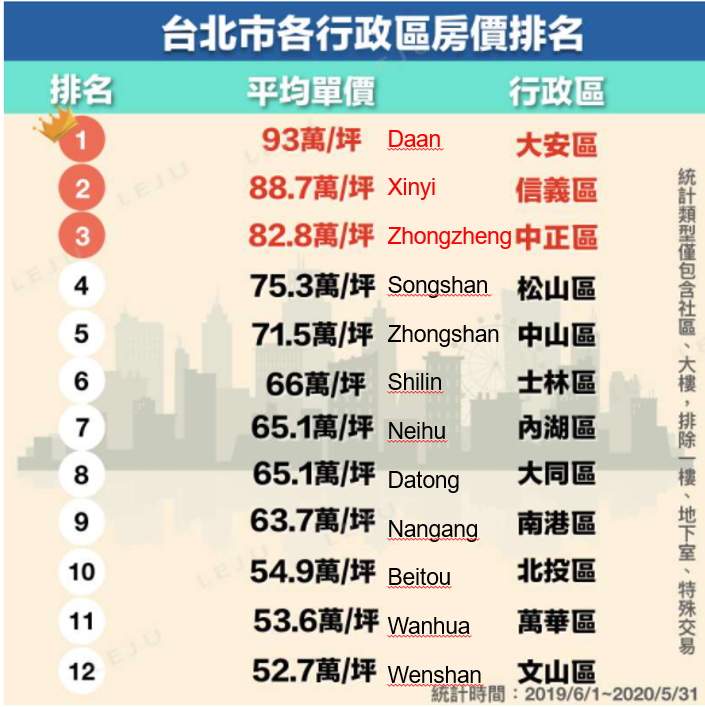

### Building age

Our result indicates that the older the house, the lower the price, which follows common sense. If we multiply the coefficient with span of feature "building age at transaction", this feature can influence around 90000 NTD in our model. This also indicates that age of house is a strong factor affecting housing price as well as the most negatively influential feature.

In [ ]:
Final_Gain_Table.loc[["building age at transaction"]]

### Building state

If we further analyze buidling state, we can see that apartment with less than 5 storey has most negative gain. In our case, building in this category are relatively low in height and has no elevator, thus it is not weird to get negative gains. The category 11storeyorgreater shows a positive gain, indicating that people still favors higher building with elevators than suite and low storey building. This somewhat explained the exploratory observation in previous section that building type affects housing price. As for other kind of building state, there are too few data in our dataset, making it really hard to reflect the influence of those categories.

In [ ]:
#Load coefficient of location related features from coefficient table
Building_State = pd.DataFrame(columns = ["Building_State","Coefficient","P value"])
for index in list(Final_Gain_Table.index):
    if "building state" in index:
        Building_State = Building_State.append({"Building_State":index,"Coefficient":Final_Gain_Table.loc[index,"Coefficient"],"P value":Final_Gain_Table.loc[index,"P value"]}, ignore_index=True)

Building_State.sort_values(by = "Coefficient", ascending = False)


### Main building material

Main building material should take effect on housing price. However, in our dataset,  most of the data belongs to reinforced concrete while other categories only occupy very minor part. This kind of distribution makes the algorithm hard to detect the influence of each category. Therefore, we do not have good fitting model on main building material.

### Other 

Some of the factors that are considered to affect housing price does not have significant result in our analysis, or some features exhibit inverse behavior as what we expected. 

First thing is shifting area. Our shifting area feature are either rejected by correlation coefficient analysis or high P value (not significant). Perhaps area only affects total price but for unit price, the price does not necessarily increase as shifting area goes high.

Second is that the number of rooms has negative gain, which is quite opposite to what we have expected. But the magnitude of gain is relatively small.

Yet some features such as management organization and elevator does not seem to have significant response to our dependent variable.

In [ ]:
#Build table for other features
Other_Table = pd.DataFrame(columns = ["Coefficient","P value"])
Other_Table["Coefficient"] = LR_OLS_result.params[["management org","elevator","num_room","land shifting total area per unit transaction"]]
Other_Table["P value"] = LR_OLS_result.pvalues[["management org","elevator","num_room","land shifting total area per unit transaction"]]
Other_Table

### Conclusion

After processing the raw data, we first start with exploratory analysis and made some observation and assumption. Subsequently, we use linear regression to help build our insight to the dataset. We eventually create a predictive linear regression model with reasonable r square, RMSE and high reproducibility.

From our model result, we found the results overall agree with our observation. Districts is one of our most powerful feature affecting housing price. Building age at transaction is the most negative impact on housing price. Finally, building state, as what we saw in exploratory observation, does have impact on housing price. Though we don't really use exactly same dataset on both tasks (exploratory analysis and regression(we delete some extreme values)), we still get a reasonable outcome to explain our assumption.

Unfortunately, some feature does not contain data with diversity or fine distribution, making it hard to capture the behavior of the feature.

## Reference
1. https://pip.moi.gov.tw/V3/E/SCRE0105.aspx
2. http://www.demographia.com/dhi.pdf
3. https://www.kaggle.com/chrischien17/taiwan-taipei-city-real-estate-transaction-records
4. https://plvr.land.moi.gov.tw/DownloadOpenData